# Welcome To The Notebook

# Fine-Tuning GPT-3.5 for Advanced Complaint Analysis at PulseNet

## Introduction
This notebook outlines the steps for fine-tuning the OpenAI GPT-3.5 model to enhance complaint analysis for PulseNet, a leading telecommunications provider. The model will be trained to extract specific details from customer complaints, including the topic, problem description, and a customer dissatisfaction index, which quantifies the severity of the complaint on a scale from 0 to 100.

## Objective
Develop a tailored Large Language Model (LLM) using the OpenAI GPT-3.5 to process and analyze customer complaints efficiently, facilitating quicker resolutions and improving customer satisfaction.

## Data
PulseNet has provided a dataset of the latest 50 customer complaints. Each entry is annotated with:
- **Topic**: The general subject of the complaint (e.g., billing, service outage).
- **Problem Description**: Detailed description of the issue.
- **Customer Dissatisfaction Index**: A numerical value between 0 and 100, representing the level of customer anger.

## Steps for Fine-Tuning
### 1. Data Preparation
- **Loading and Inspecting Data**: Load the dataset and explore its structure and contents.
- **Preprocessing**: Clean and prepare the data for model training, including tokenization and encoding.

### 2. Model Setup
- **Choosing the Model**: Set up the base GPT-3.5 model configuration suitable for fine-tuning.
- **Defining Parameters**: Establish fine-tuning parameters such as learning rate, batch size, and number of epochs.

### 3. Fine-Tuning Process
- **Training**: Implement the training loop, feeding the preprocessed data into the model.
- **Monitoring**: Track the training progress and model performance using metrics appropriate for the task.

### 4. Model Evaluation
- **Validation**: Evaluate the model on a separate validation set to ensure it generalizes well.
- **Performance Metrics**: Analyze the model's ability to extract the required information accurately.



### Step 1 - Set up the project environment

In [1]:
#!pip install openai==1.7.2 python-dotenv
#!pip install python-dotenv


Importing modules

In [2]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt



Setting up the OpenAI API:

* Prepare a .env file to store the OpenAI API key.
* Uploading the .env file to our colab environment
* Load the API key and setup the API

In [3]:
from dotenv import load_dotenv
import os

#load_dotenv()
dotenv_path = 'apikey.env'
load_dotenv(dotenv_path)

api_key = os.getenv('APIKEY')

print("API Key:", api_key)


API Key: sk-proj-o02EpdGtOKMjYQ6hNAYRT3BlbkFJIXCifdAyLrePWCvXIHJf


Creating OpenAI Client

In [4]:
client = OpenAI(
    api_key = api_key
)
client

### Step 2 - Prepare the training data

Loading the provided `Customer Complaints.csv`



In [5]:
data =  pd.read_csv("Customer Complaints.csv")
data.sample(5)

,Complaints,Details
54,I hate this!,"{""Topic"": ""PulseNet General"", ""Problem"": ""Gene..."
62,Poor call quality during international calls! ...,"{""Topic"": ""Phone"", ""Problem"": ""Poor call quali..."
50,Overpriced packages with poor service quality...,"{""Topic"": ""Billing"", ""Problem"": ""Overpriced pa..."
63,Incorrect charges on my bill every month! Unre...,"{""Topic"": ""Billing"", ""Problem"": ""Incorrect cha..."
19,Phone service blackout during emergencies! Da...,"{""Topic"": ""Phone"", ""Problem"": ""Blackout during..."


**Converting the Complaints records to json**

To be able to use the data for the fine-tuning purpose, we first need to convert each row of the dataframe into the following format:

<pre>
<code>
{
  <span style="color: blue;">"messages"</span>: [
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"system"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">Providing context about the user's prompt.
                  It may include information about the task,
                  instructions, or background details relevant
                  to the conversation.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"user"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">the prompt or input provided by the user,
                  which typically initiates the conversation with the assistant.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"assistant"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">The desired response or output generated by
                  the assistant in response to the user's prompt.</span>"
    }
  ]
}
</code>
</pre>



Let's define a method that get's a row of the dataframe and convert it into the json format

In [6]:
def save_to_json(row):

  system_content = """
      Given a customer complaint text, extract and return the following information in json (dict) format:
      - Topic: The product/department that the customer has a complaint about.
      - Problem: A two or three-word description of what exactly the problem is.
      - Customer_Dissatisfaction_Index: is a number between 0 and 100 showing
             how angry the customer is about the problem.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Complaints},
            {"role": "assistant", "content": row.Details}
        ]
      }

  with open("training_data.json", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

Now let's use of this method to generate the `training_data.json`

In [7]:
for index, row in data.iterrows():
    save_to_json(row)

### Step 3 - Fine-tune GPT 3.5 based on our training data

Let's import the json file we prepared as our training data

In [8]:
data_file =  client.files.create(
    file = open('training_data.json', 'rb'),
    purpose = "fine-tune"
)
data_file

FileObject(id='file-ehf4FmczXvMFnWzTS0jb74T7', bytes=561468, created_at=1713998933, filename='training_data.json', object='file', purpose='fine-tune', status='processed', status_details=None)

Create the Fine Tuning Job

In [9]:
fine_tuning_job = client.fine_tuning.jobs.create(
    training_file = data_file.id,
    model = "gpt-3.5-turbo",
    hyperparameters = {
        "n_epochs": 1
    }
    )
fine_tuning_job

FineTuningJob(id='ftjob-duXLSMWJNdWcuUO9DsWY8oox', created_at=1713998935, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-YbesHSOn3aPRtwCjNIX77i4C', result_files=[], status='validating_files', trained_tokens=None, training_file='file-ehf4FmczXvMFnWzTS0jb74T7', validation_file=None, user_provided_suffix=None, seed=718647022, estimated_finish=None, integrations=[])

Let's retrieve the state of the fine-tune

In [29]:
retrieved_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
status = (retrieved_job.status)
print(status)

succeeded


### Step 4 - Evaluate model

Let's retrieve the event messages to check out the learning process of our fine-tuning job.

In [30]:
events = list(client.fine_tuning.jobs.list_events(fine_tuning_job_id = retrieved_job.id, limit =100 ).data)
for event in events:
    print(event.message)

The job has successfully completed
New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal::9HgKBj6D
Step 804/804: training loss=0.00
Step 803/804: training loss=0.00
Step 802/804: training loss=0.00
Step 801/804: training loss=0.00
Step 800/804: training loss=0.00
Step 799/804: training loss=0.00
Step 798/804: training loss=0.00
Step 797/804: training loss=0.00
Step 796/804: training loss=0.00
Step 795/804: training loss=0.00
Step 794/804: training loss=0.00
Step 793/804: training loss=0.00
Step 792/804: training loss=0.00
Step 791/804: training loss=0.00
Step 790/804: training loss=0.00
Step 789/804: training loss=0.00
Step 788/804: training loss=0.00
Step 787/804: training loss=0.00
Step 786/804: training loss=0.00
Step 785/804: training loss=0.00
Step 784/804: training loss=0.00
Step 783/804: training loss=0.00
Step 782/804: training loss=0.00
Step 781/804: training loss=0.00
Step 780/804: training loss=0.00
Step 779/804: training loss=0.00
Step 778/804: training loss=0.00
Ste

Let's extract the training loss in each learning step

In [31]:
steps = []; train_loss = []
for e in events:
    if(e.data):
        steps.append(e.data['step'])
        train_loss.append(e.data['train_loss'])
        

Use a line chart to visualize the train_loss in each step

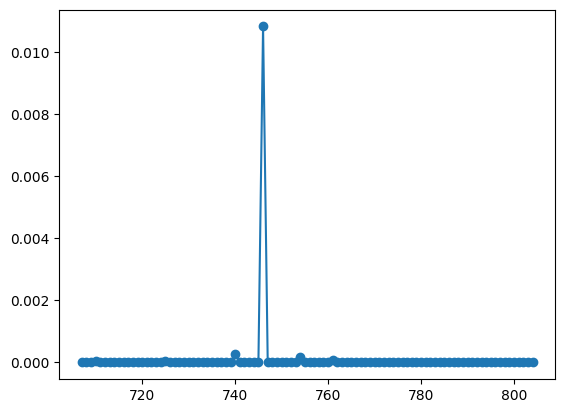

In [32]:
plt.plot(steps,train_loss, marker = 'o', linestyle = '-')

### Step 5 - Deploy our model

Let's take a look at `retrieved_job` again

In [33]:
retrieved_job

FineTuningJob(id='ftjob-duXLSMWJNdWcuUO9DsWY8oox', created_at=1713998935, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::9HgKBj6D', finished_at=1714001299, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-YbesHSOn3aPRtwCjNIX77i4C', result_files=['file-lX4MY5tjpJRyH2u2waEjCOlJ'], status='succeeded', trained_tokens=108624, training_file='file-ehf4FmczXvMFnWzTS0jb74T7', validation_file=None, user_provided_suffix=None, seed=718647022, estimated_finish=None, integrations=[])

In [34]:
myllm = retrieved_job.fine_tuned_model

Defining a method to extract information from a given user complaint using a specific LLM and return the results.

In [35]:
def extract_details(user_complaint, model_name):
    """
    This function extracts information from a given user complaint using a specific LLM (Large Language Model).

    Parameters:
    user_complaint (str): The text of the user's complaint.
    model_name (str): The name of the specific LLM model to use for extraction.
    """

    system_content = """
        Given a customer complaint text, extract and return the following information in JSON (dict) format:
        - Topic
        - Problem
        - Customer_Dissatisfaction_Index
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_complaint}  # User's complaint passed as content
        ]
    )

    # Return the content of the generated response
    return response.choices[0].message.content


Let's use our fine-tuned model to extract the details for the following user complaint:

*TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!*

In [36]:
complaint = "TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!"

Let's test our `GPT-4` model with the same user complaint

In [37]:
extract_details(complaint, myllm)

'{"Topic": "TV", "Problem": "Missing channels", "Customer_Dissatisfaction_Index": 90}'

Let's try for the following complaint:

*Line is down! It is really annoying!*

In [38]:
complaint = "Line is down! It is really annoying!"
extract_details(complaint, myllm)

'{"Topic": "Internet", "Problem": "Line down", "Customer_Dissatisfaction_Index": 9}'

Now let's compare the results from GPT-4

In [39]:
extract_details(complaint, 'gpt-4')

'{\n "Topic": "Line Issue",\n "Problem": "Line is down",\n "Customer_Dissatisfaction_Index": "High"\n}'

We can see that our model, which is trained on our dataset, provides better answers compared to GPT-4. Our model is fine-tuned based on our data and is familiar with the different edge cases and the context of our dataset.

In [40]:
complaint = "I am very Angry! I want my money back!"
extract_details(complaint, myllm)

'{"Topic": "Billing", "Problem": "General", "Customer_Dissatisfaction_Index": 10}'

In [41]:
from openai import OpenAI


stream = client.chat.completions.create(
    model= myllm,
    messages=[{"role": "user", "content": "tell me about London"}],
    stream=True,
)
for chunk in stream:
    print(chunk.choices[0].delta.content or "", end="")

London is the capital city of England and the United Kingdom, located in the southeastern part of the country along the River Thames. It is one of the most populous cities in Europe, with a diverse population representing a wide range of cultures and ethnicities.

London is known for its rich history, iconic landmarks, and vibrant cultural scene. Some of the city's most famous attractions include the Tower of London, Buckingham Palace, Big Ben, and the London Eye. The city is also home to world-class museums and galleries, such as the British Museum, Tate Modern, and the Victoria and Albert Museum.

London is a global hub for finance, commerce, and the arts, with a thriving economy and a bustling nightlife. The city is known for its excellent public transportation system, including the famous red double-decker buses and the London Underground.

Overall, London is a dynamic and cosmopolitan city that offers a unique blend of tradition and modernity, making it a popular destination for t